<a href="https://colab.research.google.com/github/JeanBaptiste-dlb/ML_quick_intro/blob/main/ml_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Machine Learning Basel Hack 2022

This notebook aims to present some Machine Learning applications in a very constrained time. 

It will contain:
- A basic supervised classification and regression
- An unsupervised clustering
- A small Computer vision application
- A small Natural Language processing application


## imports

In [77]:
from IPython.display import clear_output
!pip install pandas
!pip install sklearn
clear_output(wait=True)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [78]:
import pandas as pd
import requests
from io import StringIO
from sklearn import preprocessing
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 

## Supervised classification

## Regression
In the following example, we will try to predict the value of the houses in California based on some features. 
This problem is a regression as our label (the median house value in a district) take value in a continuous segment (approximation, intuition: there is way too many possible values for the label to consider it a classification problem). 

## get dataset

In [81]:
df_train=pd.read_csv("./sample_data/california_housing_train.csv")
df_test=pd.read_csv("./sample_data/california_housing_test.csv")

## I put the 2 dataset together because for Min Max normalization I want same scale between train and test. we will split again later.
df=pd.concat([df_train,df_test])
df=df.reset_index(drop=True)
display(df.head(5))
print(len(df))

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


20000


## Data preprocessing and preliminary data analysis

Feature normalization

In [82]:
df = df.dropna()
df["rooms_per_house"]=df["total_rooms"]/df["households"]
df["bedrooms_per_house"]=df["total_bedrooms"]/df["households"]
df["population_per_house"]= df["population"]/df["households"]

max value of population_per_house: 502.46153846153845


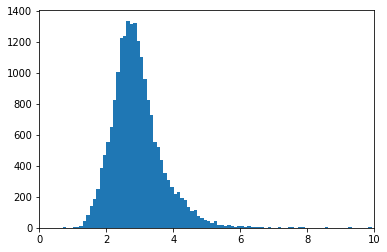

In [83]:
fig = plt.figure()
ax = plt.gca()
plt.hist(df.population_per_house, bins=5000)
ax.set_xlim([0,10]) 
print(f"max value of population_per_house: {max(df.population_per_house)}")
df.population_per_house = df.population_per_house.apply(lambda x: min(x,8) )

We observe that, here the max value is very high compared to most of the value. We may want to limit the max value by applying a threshold. We will do the same for the fields "rooms_per_house", "bedroom_per_house"

In [84]:
for i in ["rooms_per_house", "bedrooms_per_house", "population_per_house", "population"]:
  threshold = np.percentile(df[i], 99)
  df[i] = df[i].apply(lambda x: min(x, threshold)) ## 99 % of the data stays in range [0, 5.396] 

In [85]:
if ["total_rooms", "total_bedrooms", "population"] in list(df.columns):
  df.drop(columns=["total_rooms", "total_bedrooms", "population"], inplace=True)

for every field, we will apply a threshold at 99th percentile to reduce the range of values

In [86]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_per_house,population_per_house
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,-119.566172,35.626750,28.627750,2637.051550,537.991800,1403.859750,499.525450,3.872132,207082.716750,5.333331,1.076706,2.916411
std,2.003609,2.136141,12.582229,2176.314757,420.631119,973.313966,381.729517,1.900356,115557.055856,1.332782,0.162476,0.735717
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,0.846154,0.333333,0.692308
25%,-121.790000,33.930000,18.000000,1451.000000,296.000000,788.000000,280.000000,2.562500,119800.000000,4.441216,1.005913,2.430380
50%,-118.490000,34.250000,29.000000,2126.000000,434.000000,1166.000000,409.000000,3.536000,179800.000000,5.232838,1.048710,2.819566
75%,-118.000000,37.710000,37.000000,3149.000000,647.000000,1724.000000,604.000000,4.745325,265000.000000,6.056697,1.099664,3.283609
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,5804.030000,6082.000000,15.000100,500001.000000,10.385260,2.153895,5.396033


We will normalize all value in a [0, 1] frame using MinMaxScaler

In [87]:
scaler=preprocessing.MinMaxScaler() 
columns_to_transform = list(df.columns)
columns_to_transform.remove("median_house_value")
df[columns_to_transform] = scaler.fit_transform(df[columns_to_transform])

In [88]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_per_house,population_per_house
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.476477,0.328029,0.541721,0.069462,0.083332,0.241485,0.081981,0.232565,207082.716750,0.470398,0.408321,0.472839
std,0.199563,0.227008,0.246710,0.057370,0.065275,0.167783,0.062774,0.131057,115557.055856,0.139718,0.089245,0.156412
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14999.000000,0.000000,0.000000,0.000000
25%,0.254980,0.147715,0.333333,0.038197,0.045779,0.135321,0.045881,0.142246,119800.000000,0.376876,0.369435,0.369510
50%,0.583665,0.181722,0.549020,0.055991,0.067194,0.200482,0.067094,0.209383,179800.000000,0.459863,0.392943,0.452250
75%,0.632470,0.549416,0.705882,0.082958,0.100248,0.296671,0.099161,0.292784,265000.000000,0.546230,0.420931,0.550904
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,500001.000000,1.000000,1.000000,1.000000


## Loss function

To define our success in predicting the label, we will need to define a metric. We could take the mean absolute error, but the root mean squared error is generally preferred if there are not many outliers (data points with extreme values).

In [89]:
## Definition of the root mean squared error 

def se(x_predicted: float, x_real: float) -> float:
  """
  The square loss for a label and the model prediction is the L2-norm computed as (squared difference between the label and prediction) 
  """
  return (x_predicted - x_real) ** 2

def rmse(xs_predicted: list, xs_real: list)-> float:
  """
  The root mean squared error is an aggregation of the squared error over an ensemble of predition. it is computed as the Square root of the average squared error for the set of evaluated points.
  """
  MSE = np.mean([se(x_predicted, x_real) for x_predicted, x_real in zip(xs_predicted, xs_real)]) 
  return np.sqrt(MSE)

print(rmse([1,0,1], [1,0,1]))
print(rmse([1,0,1], [1,1,1])) ## square root of 1/3


0.0
0.5773502691896257


## Dataset splitting
To evaluate our model we need at least two dataset. One that is used to fit the model and one that is used to evaluate the performanse of the fitted model on unseeen data.

In [92]:
from sklearn.model_selection import train_test_split 

labels = df["median_house_value"]
features = df[columns_to_transform]

df_train, df_test, label_train, label_test = train_test_split(features, labels, test_size=0.1) ## A split with 10% of the data in the test set


## Modelling

A good first model to approach a regression problem is the linear regression as it is a very simple model that give you a first idea to the minimal performances you are able to expect. 